# Title

In [1]:
from datasets import load_dataset, Dataset
import random
from matplotlib import pyplot as plt
from collections import Counter
import re
import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt_tab')  # Ensure sentence tokenizer is available

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ENVY\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Data Preparation and Preprocessing

In [59]:
train_dataset = load_dataset("Fakhraddin/NLMCXR", split="train")
test_dataset = load_dataset("Fakhraddin/NLMCXR", split="validation")

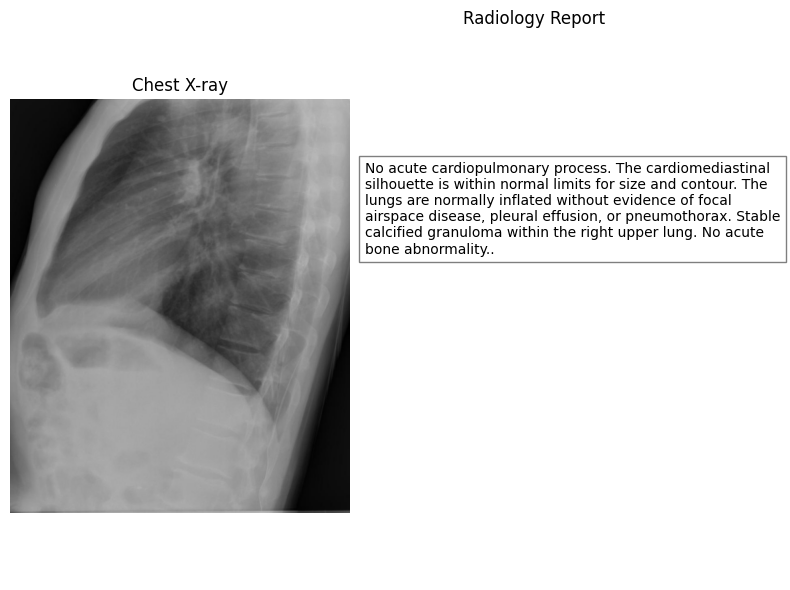

In [60]:
# Example data item
example = train_dataset[2]

# Load image
image = example['image']

# Get report
report = example['text']

# Plot
fig, ax = plt.subplots(1, 2, figsize=(8, 6))

# Left: X-ray
ax[0].imshow(image, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Chest X-ray')

# Right: Radiology Report
ax[1].text(0, 0.6, report, wrap=True, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
ax[1].axis('off')
ax[1].set_title('Radiology Report')

# plt.savefig("cxr_report_pair.png", dpi=300)
plt.tight_layout()
plt.show()

## Label Extraction

In [76]:
# Define keyword patterns for each abnormality
label_keywords = {
    "Atelectasis": [r"atelectasis", r"lung collapse"],
    "Consolidation": [r"consolidation"],
    "Infiltration": [r"infiltration"],
    "Pneumothorax": [r"pneumothorax"],
    "Edema": [r"edema", r"fluid in lungs"],
    "Emphysema": [r"emphysema"],
    "Fibrosis": [r"fibrosis"],
    "Effusion": [r"effusion"],
    "Pneumonia": [r"pneumonia"],
    "Pleural_thickening": [r"pleural thickening"],
    "Cardiomegaly": [r"cardiomegaly", r"enlarged heart"],
    "Nodule Mass": [r"nodule", r"mass"],
    "Hernia": [r"hernia"]
    # "No Finding": [r"no finding, normal"]
}

In [77]:
# Define negation patterns
negation_patterns = [
    r"\bno\b", r"\bwithout\b", r"\babsence of\b", 
    r"\bno evidence of\b", r"\bnegative for\b", r"\bnot seen\b", 
    r"\bfree of\b", r"\bunlikely\b", r"\bno findings of\b"
]

# Function to extract labels with better negation handling
def extract_labels(dataset):
    text = dataset["text"].lower()  # Convert to lowercase
    sentences = sent_tokenize(text)  # Split into sentences
    matched_labels = set()  # Use a set to avoid duplicates

    for sentence in sentences:
        for label, keywords in label_keywords.items():
            for pattern in keywords:
                if re.search(pattern, sentence):
                    # Check if any negation appears before the keyword in the same sentence
                    negation_found = any(re.search(neg, sentence) for neg in negation_patterns)
                    if not negation_found:  # Only add label if NOT negated
                        matched_labels.add(label)

    # If no conditions detected, assume "No Finding"
    dataset["extracted_labels"] = list(matched_labels) if matched_labels else ["No Finding"]
    return dataset

train_dataset = train_dataset.map(extract_labels)
test_dataset = test_dataset.map(extract_labels)

Map: 100%|██████████| 1505/1505 [00:01<00:00, 1045.35 examples/s]


In [78]:
labels = list(label_keywords.keys())
labels.append("No Finding")
print("Labels:", labels)

# Convert labels to one-hot encoding + binary label
def encode_labels(dataset):
    label_vector = {label: 0 for label in labels}
    for label in dataset["extracted_labels"]:
        if label in label_vector:
            label_vector[label] = 1
    dataset["label_vector"] = list(label_vector.values())

    # Convert to binary label (1 if any label is present, else 0)
    dataset["binary_label"] = 0 if "No Finding" in dataset["extracted_labels"] else 1
    return dataset

train_dataset = train_dataset.map(encode_labels)
test_dataset = test_dataset.map(encode_labels)

Labels: ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_thickening', 'Cardiomegaly', 'Nodule Mass', 'Hernia', 'No Finding']


Map: 100%|██████████| 1505/1505 [00:00<00:00, 1787.22 examples/s]


In [79]:
# Print a few examples with extracted labels
print("Examples with extracted labels:")
for i in range(10):
    print(f"Extracted Labels: {train_dataset[i]['extracted_labels']}")
    print(f"Label Vector: {train_dataset[i]['label_vector']}")
    print(f"Binary Label: {train_dataset[i]['binary_label']}")
    print(train_dataset[i]["text"])
    print()

Examples with extracted labels:
Extracted Labels: ['No Finding']
Label Vector: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Binary Label: 0
Normal chest x-XXXX. The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.

Extracted Labels: ['No Finding']
Label Vector: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Binary Label: 0
Normal chest x-XXXX. The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.

Extracted Labels: ['No Finding']
Label Vector: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Binary Label: 0
No acute cardiopulmonary process. The cardiomediastinal silhouette is within normal limits for size and contour. The lungs are normally inflated without evidence of focal airspace dise

In [80]:
train_dataset

Dataset({
    features: ['text', 'path', 'image', 'extracted_labels', 'label_vector', 'binary_label'],
    num_rows: 5925
})

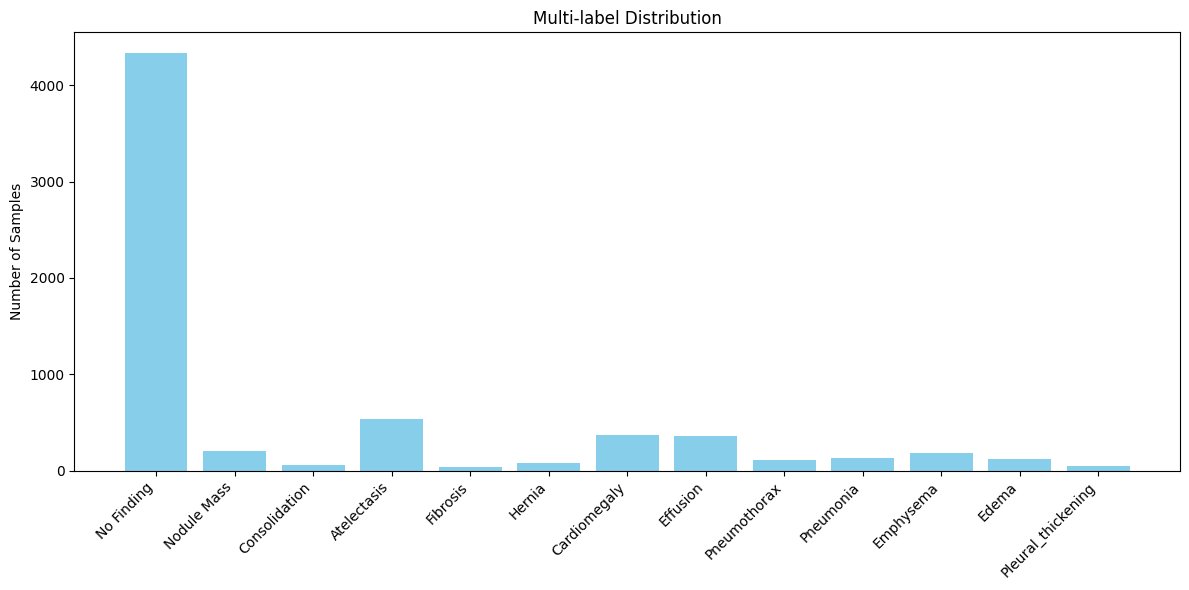

Binary Label Counts: Counter({0: 4334, 1: 1591})


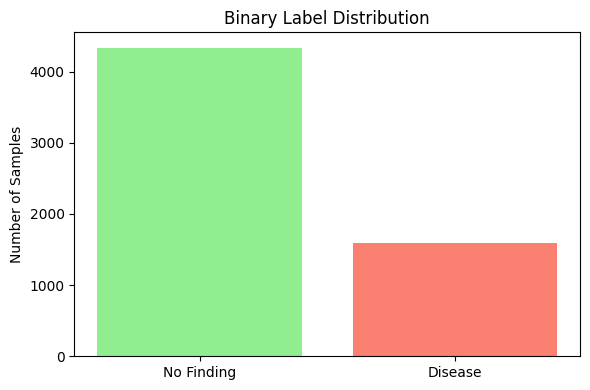

In [81]:
# Multi-label distribution (flatten and count each label)
def get_multilabel_distribution(dataset):
    counts = Counter()
    for labels in dataset["extracted_labels"]:
        counts.update(labels)
    return counts

# Binary label distribution
def get_binary_distribution(dataset):
    return Counter(dataset["binary_label"])

# Plotting
def plot_label_distribution(dataset):

    # Multi-label
    multi_counts = get_multilabel_distribution(dataset)
    plt.figure(figsize=(12, 6))
    plt.bar(multi_counts.keys(), multi_counts.values(), color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title("Multi-label Distribution")
    plt.ylabel("Number of Samples")
    plt.tight_layout()
    plt.show()

    # Binary
    binary_counts = get_binary_distribution(dataset)
    print("Binary Label Counts:", binary_counts)
    plt.figure(figsize=(6, 4))
    plt.bar(["No Finding", "Disease"], [binary_counts[0], binary_counts[1]], color=["lightgreen", "salmon"])
    plt.title("Binary Label Distribution")
    plt.ylabel("Number of Samples")
    plt.tight_layout()
    plt.show()

# Call the plot function
plot_label_distribution(train_dataset)

## Balancing the train dataset

In [82]:
import numpy as np

# Example: assuming you already have your dataset in a list of dicts
labels = [example['label_vector'] for example in train_dataset]  # shape: (num_samples, 14)
labels = np.array(labels)  # convert to numpy array of objects

label_freq = np.sum(labels, axis=0)  # total count of each label
print("Label Frequencies:", label_freq)

Label Frequencies: [ 540   57    0  113  121  182   36  364  134   52  371  203   76 4334]


In [83]:
max_count = 700

In [84]:
from collections import defaultdict

label_to_indices = defaultdict(list)
for idx, sample_labels in enumerate(labels):
    for label_idx in np.where(sample_labels == 1)[0]:
        label_to_indices[label_idx].append(idx)

In [85]:
selected_indices = set()

for label_idx in range(14):
    indices = label_to_indices[label_idx]
    if len(indices) > max_count:
        sampled = np.random.choice(indices, max_count, replace=False)
    else:
        sampled = indices
    selected_indices.update(sampled)

In [86]:
balanced_train_dataset = [train_dataset[int(i)] for i in selected_indices]
print(f"Original size: {len(train_dataset)} | Balanced size: {len(balanced_train_dataset)}")

Original size: 5925 | Balanced size: 2291


In [87]:
new_labels = np.array([example['label_vector'] for example in balanced_train_dataset])
new_freq = np.sum(new_labels, axis=0)
print("Balanced Label Frequencies:", new_freq)

Balanced Label Frequencies: [540  57   0 113 121 182  36 364 134  52 371 203  76 700]


In [88]:
balanced_train_dataset = Dataset.from_list(balanced_train_dataset)

In [89]:
balanced_train_dataset

Dataset({
    features: ['text', 'path', 'image', 'extracted_labels', 'label_vector', 'binary_label'],
    num_rows: 2291
})

In [90]:
# Save dataset in Hugging Face format
balanced_train_dataset.save_to_disk("nlmcxr_labeled_train")

Saving the dataset (1/1 shards): 100%|██████████| 2291/2291 [00:00<00:00, 3400.68 examples/s]


## Balancing the test dataset

In [91]:
# Example: assuming you already have your dataset in a list of dicts
labels = [example['label_vector'] for example in test_dataset]  # shape: (num_samples, 14)
labels = np.array(labels)  # convert to numpy array of objects

label_freq = np.sum(labels, axis=0)  # total count of each label
print("Label Frequencies:", label_freq)

Label Frequencies: [ 150   21    0   34   28   40    9   68   28   11   91   68   18 1104]


In [92]:
max_count = 200

In [93]:
label_to_indices = defaultdict(list)
for idx, sample_labels in enumerate(labels):
    for label_idx in np.where(sample_labels == 1)[0]:
        label_to_indices[label_idx].append(idx)

In [94]:
selected_indices = set()

for label_idx in range(14):
    indices = label_to_indices[label_idx]
    if len(indices) > max_count:
        sampled = np.random.choice(indices, max_count, replace=False)
    else:
        sampled = indices
    selected_indices.update(sampled)

In [95]:
balanced_test_dataset = [test_dataset[int(i)] for i in selected_indices]
print(f"Original size: {len(test_dataset)} | Balanced size: {len(balanced_test_dataset)}")

Original size: 1505 | Balanced size: 601


In [96]:
new_labels = np.array([example['label_vector'] for example in balanced_test_dataset])
new_freq = np.sum(new_labels, axis=0)
print("Balanced Label Frequencies:", new_freq)

Balanced Label Frequencies: [150  21   0  34  28  40   9  68  28  11  91  68  18 200]


In [97]:
balanced_test_dataset = Dataset.from_list(balanced_test_dataset)
balanced_test_dataset

Dataset({
    features: ['text', 'path', 'image', 'extracted_labels', 'label_vector', 'binary_label'],
    num_rows: 601
})

In [98]:
balanced_test_dataset.save_to_disk("nlmcxr_labeled_test")

Saving the dataset (1/1 shards): 100%|██████████| 601/601 [00:00<00:00, 4220.30 examples/s]
